# Support Vector Machin 구현을 통한 실제 작동 원리 실습
---
본 노트북 파일은 고려대학교 산업경영공학부 강필성 교수님의 대학원 수업인 Business Analytics 수업 내용 중 Kernel Based Learning, 특히 Support Vector Regression(SVR)을 담고 있습니다. 
본 노트북 파일의 목표는 다음과 같습니다.
- Non-Linear SVR 모델 구현을 통한 모델 이해 
- 다양한 하이퍼 파라미터 비교를 통한 모델 이해 

## 1. SVR 이란?
### SVR이란 Support Vector를 이용하여 회귀선을 추정하는 방법론입니다. 이름에서 알 수 있듯이 분류 문제에 널리 활용되던 SVM 모델의 Support Vector 개념을 이용하여 회귀 문제를 해결하고자 하는 방향성을 가지고 있습니다. 

### 이때 SVM은 아래 그림처럼 마진의 경계상 혹은 경계 내부(Soft Margin 적용 시)의 data point를 Support Vector로 활용하지만, SVR은 이와 반대로 마진의 외부 혹은 경계 상의 data point를 Support Vector로 활용합니다. 이를 통해 다른 모델과 비교하여 노이즈와 과적합에 강건한 모델이라는 특징을 가지고 있습니다. 이러한 특징은 릿지 회귀와 비슷한 목적함수를 가지는데 기인한다고 볼 수 있습니다!
<figure class="half">
    <img src="SVM.png" title="SVM" height="200">
    <img src="SVR.png" title="SVR" height="200">
<figure>

이미지 출처 : https://www.saedsayad.com/modeling.htm

## 본 노트북 파일에서 다루고자 하는 SVR의 요소는 다음과 같습니다. 
1. 커널 트릭
2. 커널 트릭 별 Hyperparameter
3. 위 요소들의 노이즈에 대한 강건함

## 1. 데이터
Swiss Roll 데이터를 이용하여 실험을 진행하도록 하겠습니다. Swiss Roll 데이터는 실제 2차원의 매니폴드를 가지는 데이터로서, 비선형 모델링을 통해 효과적인 적합이 가능한 데이터입니다. 비선형 데이터가 필요하기 때문에 Swiss Roll 데이터에서 첫 두차원만 사용하도록 하겠습니다.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np 
import copy
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles
np.random.seed(0)
X = np.sort(20 * np.random.rand(300, 1), axis=0)
y = np.sin(X).ravel()

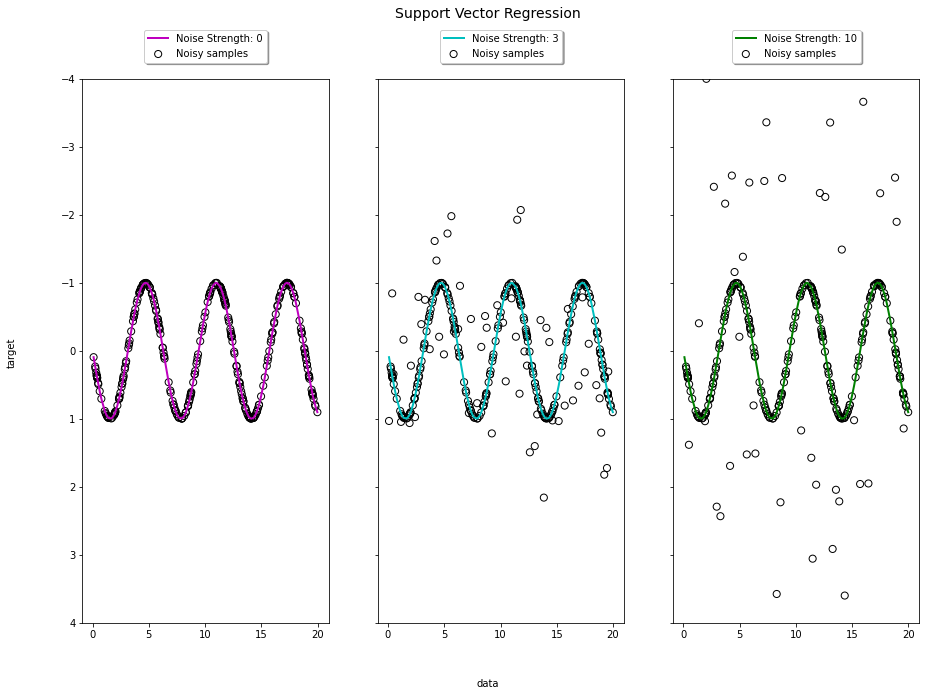

In [2]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 10), sharey=True)
# 데이터에 노이즈를 추가합니다. 
noise_list = [0, 3, 10]
color_list = ["m", "c", "g"]
lw = 2

for ix, noise in enumerate(noise_list):
    y_tmp = copy.deepcopy(y)
    y_tmp[::5] += noise * (0.5 - np.random.rand(len(y_tmp)//5))

    axes[ix].plot(
        X,
        y,
        color=color_list[ix],
        lw=lw,
        label=f"Noise Strength: {noise}",
    )
    axes[ix].scatter(
        X,
        y_tmp,
        facecolor="none",
        edgecolor="k",
        s=50,
        label="Noisy samples",
    )
    axes[ix].legend(
        loc="upper center",
        bbox_to_anchor=(0.5, 1.1),
        ncol=1,
        fancybox=True,
        shadow=True,
    )
    axes[ix].set_ylim(4, -4)

fig.text(0.5, 0.04, "data", ha="center", va="center")
fig.text(0.06, 0.5, "target", ha="center", va="center", rotation="vertical")
fig.suptitle("Support Vector Regression", fontsize=14)
plt.show()

데이터는 위와 같이 Sin 함수를 띄고 있으며, 단순 선형 회귀 등을 통해서는 적합시킬 수 없습니다. 특히 노이즈의 수는 동일하나, 데이터마다 노이즈의 강도가 다르다는 특징을 가지고 있는 점을 볼 수 있습니다. SVR은 기존의 Ridge Regression과 다르게 Support Vector만 이용하여 회귀선을 적합하기 때문에, 노이즈의 강도가 각 모델에 어떠한 영향을 미치는지 살펴보도록 합시다. 

# 2. 커널 별 데이터 적합도

For kernel: linear, noise: 0
For kernel: linear, noise: 3
For kernel: linear, noise: 10
For kernel: poly, noise: 0
For kernel: poly, noise: 3
For kernel: poly, noise: 10
For kernel: rbf, noise: 0
For kernel: rbf, noise: 3
For kernel: rbf, noise: 10
For kernel: sigmoid, noise: 0
For kernel: sigmoid, noise: 3
For kernel: sigmoid, noise: 10


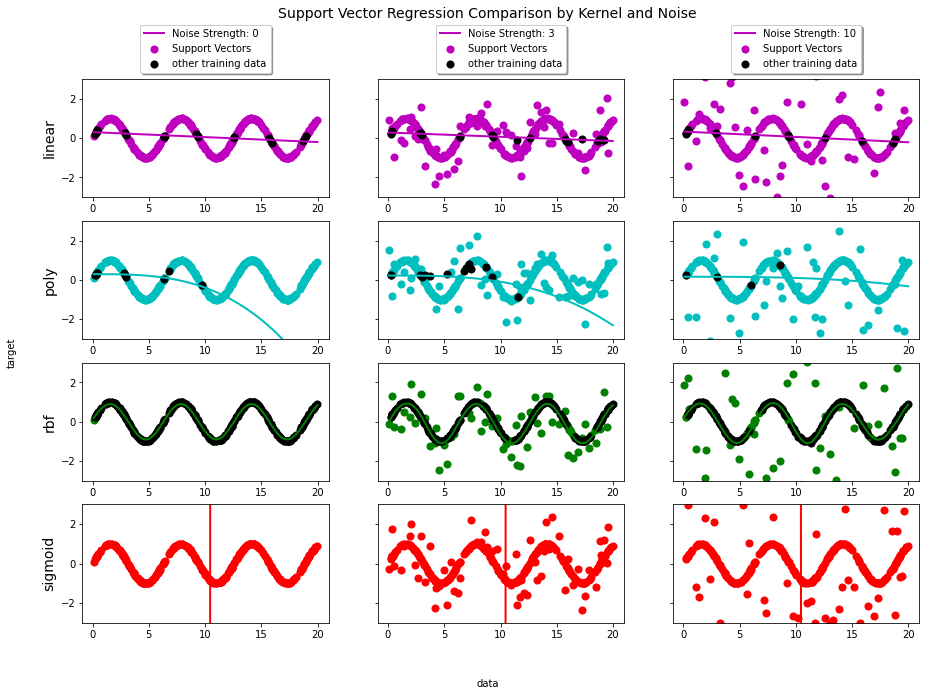

In [3]:
from sklearn.svm import SVR
kernel_list = ["linear", "poly", "rbf", "sigmoid"]
color_list = ["m", "c", "g", "r"]
noise_list = [0, 3, 10]

lw = 2

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 10), sharey=True)

for row, kernel in enumerate(kernel_list) :
    for col, noise in enumerate(noise_list) :
        print(f"For kernel: {kernel}, noise: {noise}")
        y_tmp = copy.deepcopy(y)
        y_tmp[::5] += noise * (0.5 - np.random.rand(len(y_tmp)//5))

        svr = SVR(kernel=kernel, C=1e3, gamma=0.1)
        y_svr = svr.fit(X, y_tmp).predict(X)

        axes[row,col].plot(
            X,
            y_svr,
            color=color_list[row],
            lw=lw,
            label=f"Noise Strength: {noise}",
        )
        
        axes[row,col].scatter(
            X[svr.support_],
            y_tmp[svr.support_],
            facecolor=color_list[row],
            s=50,
            label=f"Support Vectors",
        )

        axes[row,col].scatter(
            X[np.setdiff1d(np.arange(len(X)), svr.support_)],
            y_tmp[np.setdiff1d(np.arange(len(X)), svr.support_)],
            facecolor="k",
            s=50,
            label="other training data",
        )   
        if row == 0 :
            axes[row,col].legend(
                loc="upper center",
                bbox_to_anchor=(0.5, 1.5),
                ncol=1,
                fancybox=True,
                shadow=True,
            )
        if col == 0 :
            axes[row,col].set_ylabel(kernel, fontsize=14)

        axes[row, col].set_ylim(-3, 3)

fig.text(0.5, 0.04, "data", ha="center", va="center")
fig.text(0.06, 0.5, "target", ha="center", va="center", rotation="vertical")
fig.suptitle("Support Vector Regression Comparison by Kernel and Noise", fontsize=14)
plt.show()

위 그림에서 색으로 표시된 점은 Support Vector를, 검은 점은 Margin 내부의 점으로 Support Vector가 아닌 점을 보여주고 있습니다. 각 커널은 최대한 기본 파라미터를 사용했습니다. 
위 그림을 통해 다음과 같은 결론을 내릴 수 있습니다. 
1. 첫번째 열을 살펴보면, 노이즈가 전혀 없는 상태의 데이터에서 각 커널 별 모델 적합을 보여주고 있습니다. 이때, Linear 커널의 경우 데이터의 선형관계만 표현 가능하기 때문에, Sin 함수를 띄는 본 데이터에서 전혀 적합되지 못한 것을 볼 수 있습니다. 또한, Sigmoid 커널 역시 제대로 적합되지 못하고 모든 데이터를 Support Vector로 사용하는 모습을 볼 수 있습니다. 
2. 첫번재 행을 살펴보면 Linear 커널인데, Linear 커널의 경우 제대로 적합되지 못하지만, Sin 함수의 특성 상 가우시안 노이즈에 대해 동일한 E(y)가 유지되므로 적합선이 거의 변하지 않는 것을 볼 수 있습니다. 
3. 두번째 행을 살펴보면 Polynomial 커널인데, 노이즈에 매우 민감하게 반응하는 것을 볼 수 있습니다. 이는, Polynomal 커널이 Sin 함수의 모함수에 대해 적합한 커널이 아니기 때문입니다. Polynomial 커널은 확대할 차원을 결청하는 파라미터인 D에 따라 모델의 표현력이 결정됩니다. 이때, 기본값인 3으로 설정되어 있으므로 모함수를 표현하기 충분한 표현력을 가지지 못했다는 점이 원인이라 할 수 있습니다. 
4. 세번째 행을 살펴보면 RBF 커널인데, 노이즈에 매우 강건하고, 매우 잘 적합하고 있는 것을 볼 수 있습니다. 가우시안 커널은 그 특성 상 이론적으로 무한차원의 표현력을 가진다고 할 수 있습니다. 이러한 특징이 매우 잘 드러나는 그림입니다. 또한, 모델의 표현력이 충분한 상황에서 해당 데이터 수준의 노이즈는 SVR 학습에 거의 영향을 끼치지 못하는 점을 알 수 있습니다. 
5. 네번째 행을 살펴보면 Sigmoid 커널입니다. Sigmoid 커널은 하이퍼 파라미터인 gamma에 매우 민감하며, gamma를 조절하면 RBF 커널과 유사한 성질을 가지는 특징이 있습니다. 자세한 내용은 아래에서 살펴보도록 하겠습니다. 

# 3. Polynomial Kernel의 하이퍼 파라미터 조정

For degree: 1, noise: 0
For degree: 1, noise: 3
For degree: 1, noise: 10
For degree: 3, noise: 0
For degree: 3, noise: 3
For degree: 3, noise: 10
For degree: 5, noise: 0
For degree: 5, noise: 3
For degree: 5, noise: 10


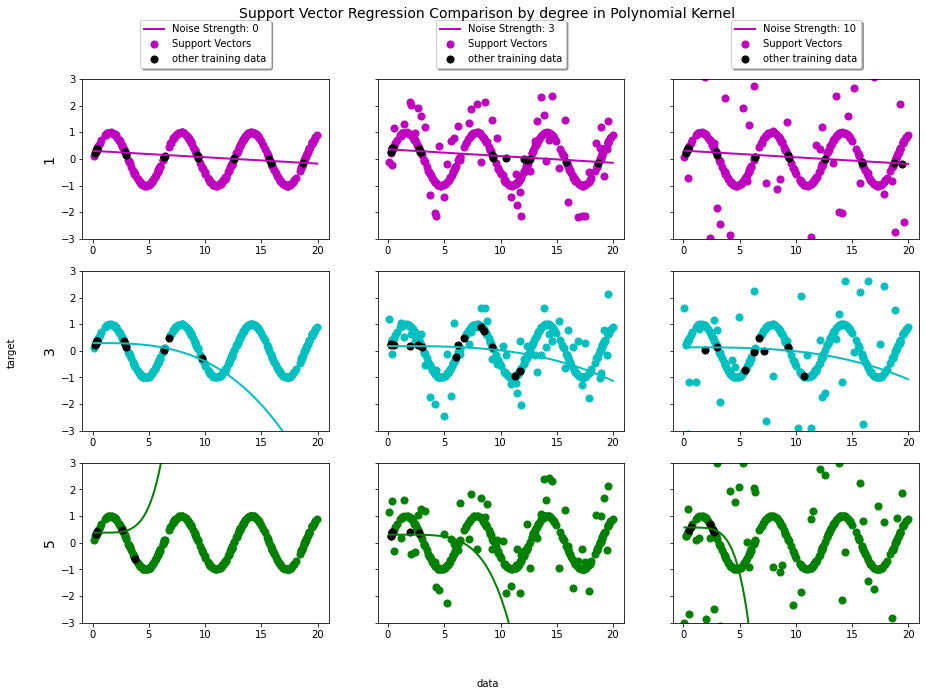

In [20]:
from sklearn.svm import SVR
kernel = "poly"
degree_list = [1, 3, 5]
color_list = ["m", "c", "g", "r"]
noise_list = [0, 3, 10]

lw = 2

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10), sharey=True)

for row, degree in enumerate(degree_list) :
    for col, noise in enumerate(noise_list) :
        print(f"For degree: {degree}, noise: {noise}")
        y_tmp = copy.deepcopy(y)
        y_tmp[::5] += noise * (0.5 - np.random.rand(len(y_tmp)//5))

        svr = SVR(kernel=kernel, C=1e3, gamma=0.1, degree=degree)
        y_svr = svr.fit(X, y_tmp).predict(X)

        axes[row,col].plot(
            X,
            y_svr,
            color=color_list[row],
            lw=lw,
            label=f"Noise Strength: {noise}",
        )

        axes[row,col].scatter(
            X[svr.support_],
            y_tmp[svr.support_],
            facecolor=color_list[row],
            s=50,
            label=f"Support Vectors",
        )

        axes[row,col].scatter(
            X[np.setdiff1d(np.arange(len(X)), svr.support_)],
            y_tmp[np.setdiff1d(np.arange(len(X)), svr.support_)],
            facecolor="k",
            s=50,
            label="other training data",
        )   
        if row == 0 :
            axes[row,col].legend(
                loc="upper center",
                bbox_to_anchor=(0.5, 1.4),
                ncol=1,
                fancybox=True,
                shadow=True,
            )
        if col == 0 :
            axes[row,col].set_ylabel(degree, fontsize=14)

        axes[row, col].set_ylim(-3, 3)

fig.text(0.5, 0.04, "data", ha="center", va="center")
fig.text(0.06, 0.5, "target", ha="center", va="center", rotation="vertical")
fig.suptitle("Support Vector Regression Comparison by degree in Polynomial Kernel", fontsize=14)
plt.show()

위 그림은 Polynomial Kernel 사용 시 Degree 및 Noise 정도에 따른 결과를 보여주고 있다. Sin 함수의 특성 상 Polynomial Kernel로 적절히 적합하기 위해선 매우 고차원이 필요하다. 하지만, 5차원 이상으로 Kernel의 차원을 늘릴 경우, 적합하는데 1시간이 넘게 소요되는 등 매우 막대한 연산량이 필요하다. RBF 커널을 사용할 경우, 큰 Hyper-Parameter Search 없이도, 매우 단시간(3 ~ 5분) 내에 모회귀선에 근접한 회귀선을 형성할 수 있다는 점에서, Polynomial Kernel이 특정 데이터 형태에 매우 비효율적으로 작동한다는 점을 알 수 있다. 즉, Kernel Trick을 이용하여 고차원을 이용하고자 할 때, RBF 커널을 제외한 다른 커널의 경우 데이터 특성을 고려하여 사용해야 효과적으로 적합이 가능하다는 점을 알 수 있다. RBF 커널의 경우 이론상 무한개의 점을 Shatter할 수 있기 때문에, 데이터 특성에 비교적 강건한 모습을 보인다. 

또한, Polynomal 커널 사용 시 마지막 행을 살펴보면, 오히려 1, 3차원의 저차원 모델보다 5차원의 고차원 모델이 노이즈에 매우 민감하게 반응한다는 것을 알 수 있다. 즉, Polynomial 커널은 데이터에 적합하기 위해 필요한 이론적 차원인 8차원보다 적은 차원임에도, 쉽게 과적합이 가능하다. 

# 4. RBF 커널의 노이즈 수 및 위치에 따른 특징 

For noise_interval: 2, noise_position: 0.25
For noise_interval: 2, noise_position: 0.5
For noise_interval: 2, noise_position: 0.75
For noise_interval: 4, noise_position: 0.25
For noise_interval: 4, noise_position: 0.5
For noise_interval: 4, noise_position: 0.75
For noise_interval: 10, noise_position: 0.25
For noise_interval: 10, noise_position: 0.5
For noise_interval: 10, noise_position: 0.75


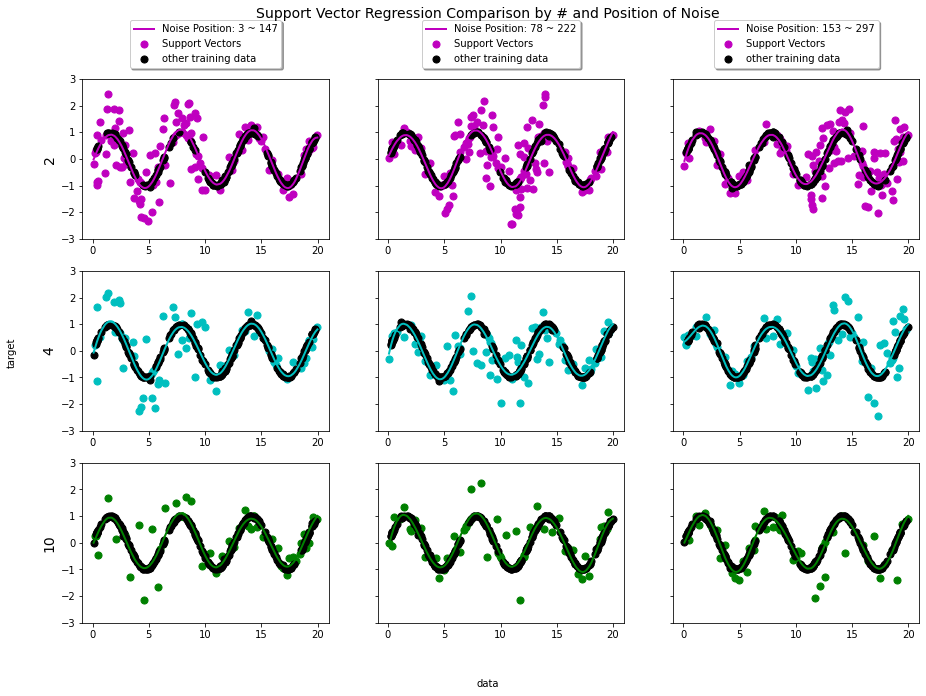

In [32]:
from sklearn.svm import SVR
kernel = "rbf"
color_list = ["m", "c", "g", "r"]
noise = 3
noise_interval_list = [2, 4, 10]
noise_position_list = [0.25, 0.5, 0.75]

lw = 2

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10), sharey=True)

for row, noise_interval in enumerate(noise_interval_list) :
    for col, noise_position in enumerate(noise_position_list) :
        print(f"For noise_interval: {noise_interval}, noise_position: {noise_position}")
        y_len = len(y)
        y_original = copy.deepcopy(y)
        y_tmp = copy.deepcopy(y)
        y_original[::5] += 1 * (0.5 - np.random.rand(len(y_tmp)//5))
        y_tmp[::noise_interval] += noise * (0.5 - np.random.rand(round(len(y_tmp)/noise_interval)))
        y_original[int(y_len*(noise_position-0.24)): int(y_len*(noise_position+0.24))] = y_tmp[int(y_len*(noise_position-0.24)): int(y_len*(noise_position+0.24))] 
        y_tmp = y_original
        
        svr = SVR(kernel=kernel, C=1e3, gamma=0.1, degree=degree)
        y_svr = svr.fit(X, y_tmp).predict(X)

        axes[row,col].plot(
            X,
            y_svr,
            color=color_list[row],
            lw=lw,
            label=f"Noise Position: {int(y_len*(noise_position-0.24)) } ~ {int(y_len*(noise_position+0.24))}",
        )

        axes[row,col].scatter(
            X[svr.support_],
            y_tmp[svr.support_],
            facecolor=color_list[row],
            s=50,
            label=f"Support Vectors",
        )

        axes[row,col].scatter(
            X[np.setdiff1d(np.arange(len(X)), svr.support_)],
            y_tmp[np.setdiff1d(np.arange(len(X)), svr.support_)],
            facecolor="k",
            s=50,
            label="other training data",
        )   
        if row == 0 :
            axes[row,col].legend(
                loc="upper center",
                bbox_to_anchor=(0.5, 1.4),
                ncol=1,
                fancybox=True,
                shadow=True,
            )
        if col == 0 :
            axes[row,col].set_ylabel(noise_interval, fontsize=14)

        axes[row, col].set_ylim(-3, 3)

fig.text(0.5, 0.04, "data", ha="center", va="center")
fig.text(0.06, 0.5, "target", ha="center", va="center", rotation="vertical")
fig.suptitle("Support Vector Regression Comparison by # and Position of Noise", fontsize=14)
plt.show()

노이즈의 위치와 갯수에 따른 RBF 커널의 변화를 살펴보자. 첫번째 열은 X가 작은 값(하위 25%)일 때, 큰 노이즈가 위치하고, 가운데 열은 X가 중위값에 가까울 때(25 ~ 75%)일 때, 큰 노이즈가 위치하고, 오른쪽 열은 X가 큰 값(상위 25% ~ 100%)일 때, 큰 노이즈가 존재하는 것을 볼 수 있다. 또한, 아래 행으로 갈 수록 더 적은 노이즈가 존재한다. 모든 행과 열에서 일관적으로 모회귀선과 매우 유사한 회귀선을 적합한 것을 볼 수 있다. 이를 통해 RBF 커널은 노이즈의 위치 혹은 갯수에 매우 강건하다는 점을 알 수 있다. 이는 기존의 선형회귀식이 모든 데이터를 이용하여 모든 구간에 영향을 주는 것과 다르게 SVR은 대부분의 데이터가 Support Vector로 사용되지 않도록 적합하는 과정에서 Support Vector의 영향력을 최소화할 수 있기 때문에 가능한 것으로 보인다. 

# 5. RBF 커널에서의 epsilon에 따른 변화 

For epsilon: 0.1, noise: 0
For epsilon: 0.1, noise: 3
For epsilon: 0.1, noise: 6
For epsilon: 1, noise: 0
For epsilon: 1, noise: 3
For epsilon: 1, noise: 6
For epsilon: 2, noise: 0
For epsilon: 2, noise: 3
For epsilon: 2, noise: 6


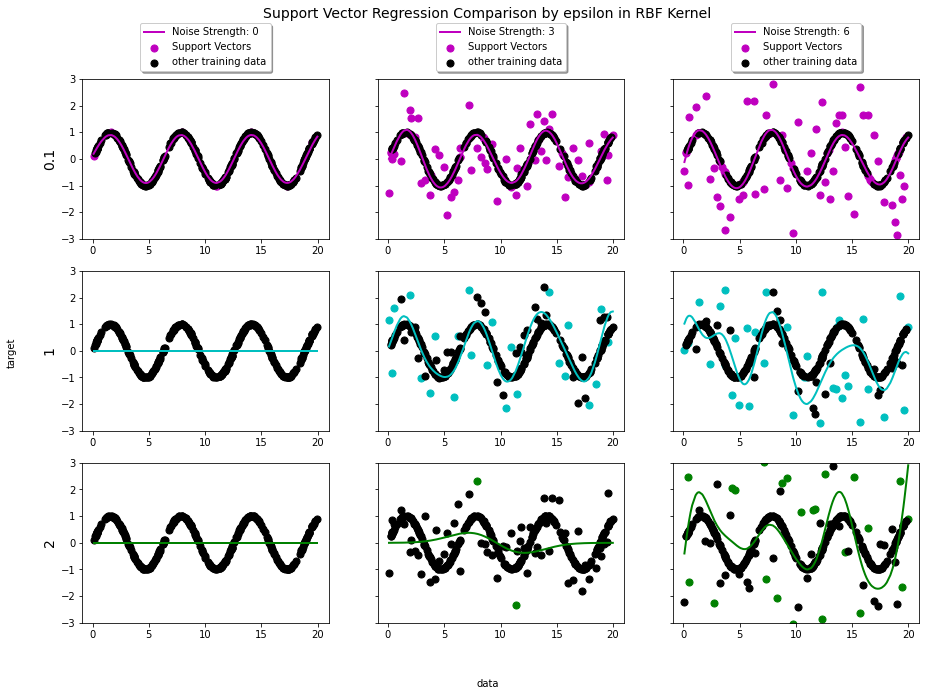

In [5]:
from sklearn.svm import SVR
kernel = "rbf"
color_list = ["m", "c", "g", "r"]
noise_list = [0, 3, 6]
epsilon_list = [0.1, 1, 2]

lw = 2

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10), sharey=True)

for row, epsilon in enumerate(epsilon_list) :
    for col, noise in enumerate(noise_list) :
        print(f"For epsilon: {epsilon}, noise: {noise}")
        y_tmp = copy.deepcopy(y)
        y_tmp[::5] += noise * (0.5 - np.random.rand(len(y_tmp)//5))

        svr = SVR(kernel=kernel, C=1e3, gamma=0.1, epsilon=epsilon)
        y_svr = svr.fit(X, y_tmp).predict(X)

        axes[row,col].plot(
            X,
            y_svr,
            color=color_list[row],
            lw=lw,
            label=f"Noise Strength: {noise}",
        )
        
        axes[row,col].scatter(
            X[svr.support_],
            y_tmp[svr.support_],
            facecolor=color_list[row],
            s=50,
            label=f"Support Vectors",
        )

        axes[row,col].scatter(
            X[np.setdiff1d(np.arange(len(X)), svr.support_)],
            y_tmp[np.setdiff1d(np.arange(len(X)), svr.support_)],
            facecolor="k",
            s=50,
            label="other training data",
        )   
        if row == 0 :
            axes[row,col].legend(
                loc="upper center",
                bbox_to_anchor=(0.5, 1.38),
                ncol=1,
                fancybox=True,
                shadow=True,
            )
        if col == 0 :
            axes[row,col].set_ylabel(epsilon, fontsize=14)

        axes[row, col].set_ylim(-3, 3)

fig.text(0.5, 0.04, "data", ha="center", va="center")
fig.text(0.06, 0.5, "target", ha="center", va="center", rotation="vertical")
fig.suptitle("Support Vector Regression Comparison by epsilon in RBF Kernel", fontsize=14)
plt.show()

epsilon은 Soft Margin을 가지는 SVR에서 회귀선에서 어느 범위까지의 데이터를 Support Vector로 여길지를 결정하는 요소이다. 즉, epsilon보다 회귀선과 가까운 데이터에 대해선 패널티를 부여하지 않는다. 반대로 이야기하면, epsilon이 클수록, 실제값과 예측값이 회귀선 건너편에 위치하는 데이터에 대해 패널티가 부여되지 않는다. 이로인해 epsilon이 커질수록 모델은 노이즈에 강건해지지만, 너무 큰 epsilon은 데이터 적합에 방해가 되기도 한다. 만약 커널 트릭을 사용할 경우 고차원 상에서 형성되는 회귀선에 적용되는 개념이기 때문에 실제 데이터에서 직관적으로 포착되지 않을 수 있다. 하지만 위 결과에 대한 결론을 정리하면 다음과 같다. 

1. 첫번째 열을 관찰하면, 너무 큰 epsilon 값을 사용할 경우 모델이 적합하지 못하는 문제점이 발생한다. 이는 epsilon이 작은 경우 모델이 잘 적합하면서 모회귀선에 해당하는 데이터들이 Margin 내부에 들어오는 모습과 반대로, epsilon이 1 또는 2일 때, 모회귀선의 데이터들이 큰 epsilon으로 인해 모두 Support Vector로 사용되지 않으면서도, 적합된 회귀선이 전혀 모회귀선을 따르지 못하는 모습을 통해 확인할 수 있다. 
2. 노이즈가 많은 데이터의 경우, epsilon 값은 작아야한다. noise가 매우 큰 경우(세번째 열)에도 epsilon 값이 작다 하더라도 모회귀선과 근접하도록 회귀선이 선택된 것을 알 수 있다. 이는, SVR이 큰 노이즈에도 강건하게 작동하도록 Support Vector를 선택하게 학습되기 때문이다. 
3. Support Vector는 다소 직관적이지 못하다. 커널 트릭을 사용하는 경우 Kernel이 생성하는 고차원 공간에서 Support Vector가 형성되기 때문에, 원 공간에서 Support Vector들은 다소 직관적이지 못한 모습을 보이는 것을 알 수 있다. 

# 6. C 조절에 따른 RBF 커널 SVR의 변화 

For C: 1000.0, noise: 1
For C: 1000.0, noise: 3
For C: 1000.0, noise: 6
For C: 100000.0, noise: 1
For C: 100000.0, noise: 3
For C: 100000.0, noise: 6
For C: 1000000.0, noise: 1
For C: 1000000.0, noise: 3
For C: 1000000.0, noise: 6


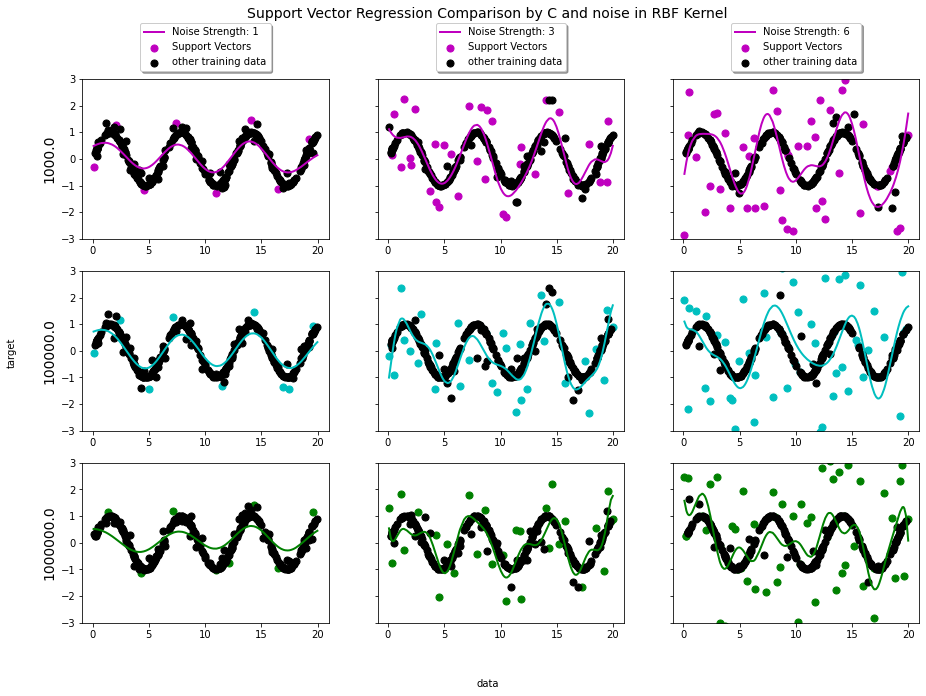

In [3]:
from sklearn.svm import SVR
kernel = "rbf"
epsilon = .8
color_list = ["m", "c", "g", "r"]
noise_list = [1, 3, 6]
C_list = [1e3, 1e5, 1e6]

lw = 2

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10), sharey=True)

for row, C in enumerate(C_list) :
    for col, noise in enumerate(noise_list) :
        print(f"For C: {C}, noise: {noise}")
        y_tmp = copy.deepcopy(y)
        y_tmp[::5] += noise * (0.5 - np.random.rand(len(y_tmp)//5))

        svr = SVR(kernel=kernel, C=C, gamma=0.1, epsilon=epsilon)
        y_svr = svr.fit(X, y_tmp).predict(X)

        axes[row,col].plot(
            X,
            y_svr,
            color=color_list[row],
            lw=lw,
            label=f"Noise Strength: {noise}",
        )
        
        axes[row,col].scatter(
            X[svr.support_],
            y_tmp[svr.support_],
            facecolor=color_list[row],
            s=50,
            label=f"Support Vectors",
        )

        axes[row,col].scatter(
            X[np.setdiff1d(np.arange(len(X)), svr.support_)],
            y_tmp[np.setdiff1d(np.arange(len(X)), svr.support_)],
            facecolor="k",
            s=50,
            label="other training data",
        )   
        if row == 0 :
            axes[row,col].legend(
                loc="upper center",
                bbox_to_anchor=(0.5, 1.38),
                ncol=1,
                fancybox=True,
                shadow=True,
            )
        if col == 0 :
            axes[row,col].set_ylabel(C, fontsize=14)

        axes[row, col].set_ylim(-3, 3)

fig.text(0.5, 0.04, "data", ha="center", va="center")
fig.text(0.06, 0.5, "target", ha="center", va="center", rotation="vertical")
fig.suptitle("Support Vector Regression Comparison by C and noise in RBF Kernel", fontsize=14)
plt.show()

위 그림은 C와 노이즈 강도의 변화에 따른 RBF 커널의 변화를 보여주고 있다. 이때 본래의 RBF 커널은 노이즈에 매우 강건한 모습을 보여줬지만(5번 실험 참조), 의도적으로 노이즈에 민감하도록 epsilon 값을 조정하였다. SVR에서 C는 회귀선이 학습 데이터에 적합되도록 부여되는 패널티의 가중치를 의미한다. 즉, C의 값이 클수록 SVR은 weight의 크기가 커져서 Margin이 커지더라도, 실제 데이터에 적합되도록 회귀선이 형성된다. 이는 위 실험을 통해서도 잘 드러나고 있다. 실험을 정리하면 다음과 같다. 

1. C가 큰 값을 가지면, 노이즈가 많은 데이터에 매우 민감하게 반응한다. 오른쪽 열을 비교해보면 이러한 결과는 극명히 드러난다. C가 매우 큰 경우 상대적으로 작은 C를 가지는 모델들에 비해 복잡한 회귀선을 형성한 것을 볼 수 있다. 이는, Support Vector를 이용하여 회귀선 적합이 매우 강한 패널티로 인해 노이즈에 민감해진 결과이다. 이는 실제 모회귀선에 비해 복잡해지면서 모델이 노이즈까지 학습해버리는 과적합을 초래했다. 
2. 적절한 C 값을 가질 경우 상대적으로 큰 epsilon 값을 가지더라도 적절히 데이터에 적합 가능하다. C값이 크지 않은 첫번째 행을 살펴보면, 노이즈가 많은 경우에도 비교적 잘 회귀선을 적합하고 있는 것을 볼 수 있다. 위 실험이 의도적으로 epsilon을 조절하여 노이즈에 민감한 모델을 설정한 상황임을 가정할 때, 실제 데이터에 적합되는 패널티의 가중치 역할을 하는 C가 적절히 작은 값을 가질 수 있다면, 과적합되지 않는 것을 알 수 있다. 이는, Margin을 통해 weight에 패널티를 부여하는 SVR의 강력한 장점이라 할 수 있을 것이다. 